In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import time

from skmultilearn.model_selection import iterative_train_test_split
import random

import torch.optim as optim
import os
import tqdm

from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score,precision_recall_fscore_support,classification_report


In [3]:
!mkdir model_ckpt

mkdir: cannot create directory 'model_ckpt': File exists


In [4]:
!mkdir stats

mkdir: cannot create directory 'stats': File exists


# Read data

In [5]:
df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# EDA

### Distribution of labels

In [6]:
labels =  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [7]:
# labels distribution
positive_class_ratio = round(100*df[df.columns[2:]].sum()/len(df),2).sort_values()
positive_class_ratio

threat           0.30
identity_hate    0.88
severe_toxic     1.00
insult           4.94
obscene          5.29
toxic            9.58
dtype: float64

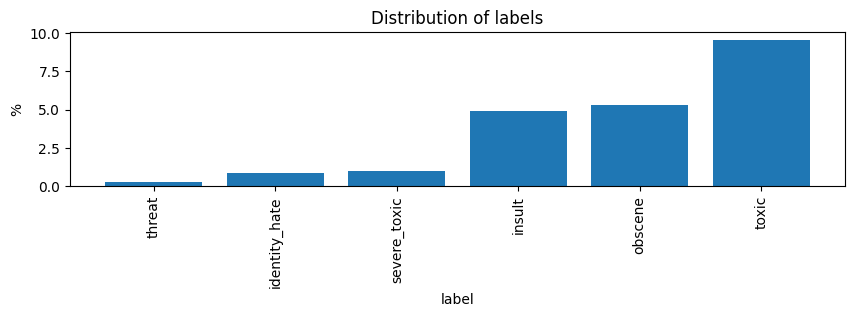

In [8]:
plt.figure(figsize=(10,2))
plt.bar(positive_class_ratio.index, positive_class_ratio.values,)
plt.xlabel("label")
plt.ylabel("%")
plt.title("Distribution of labels")
plt.xticks(rotation=90)
plt.show()

- Clearly, there is an **imbalance** between the 6 categories. Comments with `threat` label are the least common.
- There is also an imbalance within each label as the proportion of positive class is less than **10%** for all categories, and less than **1%** for three categories: `sever_toxic`, `identity_hate` and `threat`. 

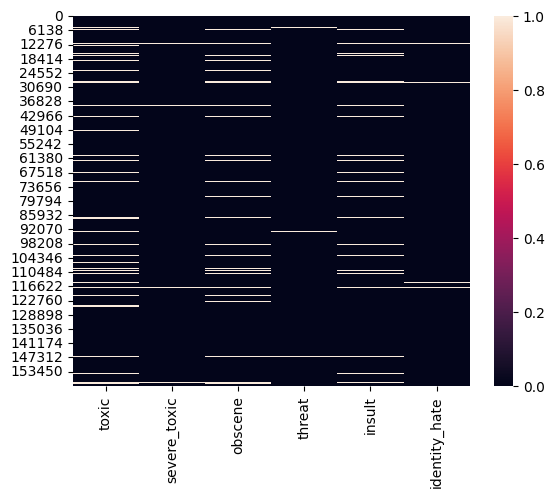

In [9]:
sns.heatmap(df[df.columns[2:]]);

- The heatmap shows that there is a strong correlation between the terms _`toxic`_, _`obscene`_ and _`insult`_.
- Therefore, if a comment has one of these three labels, it is likely to have the others as well.

### Correlation matrix

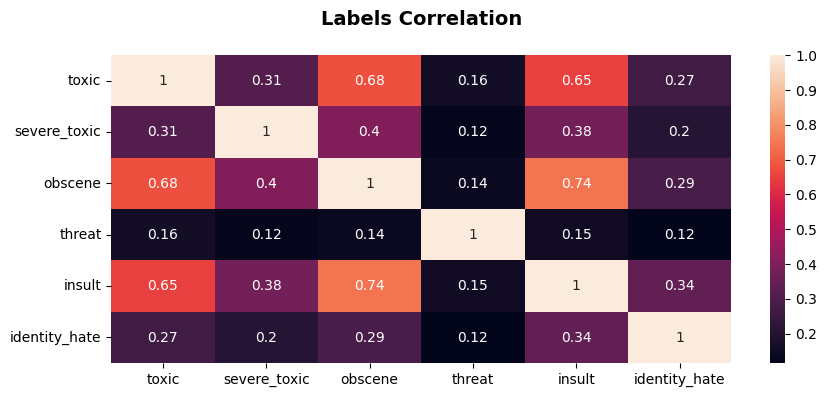

In [10]:
labels_corr = df.drop(["id","comment_text"],axis=1).corr()

plt.figure(figsize=(10,4))
sns.heatmap(labels_corr, annot=True)
plt.title("Labels Correlation\n",size = 14, weight = 'bold');

### Length of the comments - number of words

In [11]:
# Add column "comment_length"
df["comment_length"] = df["comment_text"].apply(lambda x:len(x.split()))

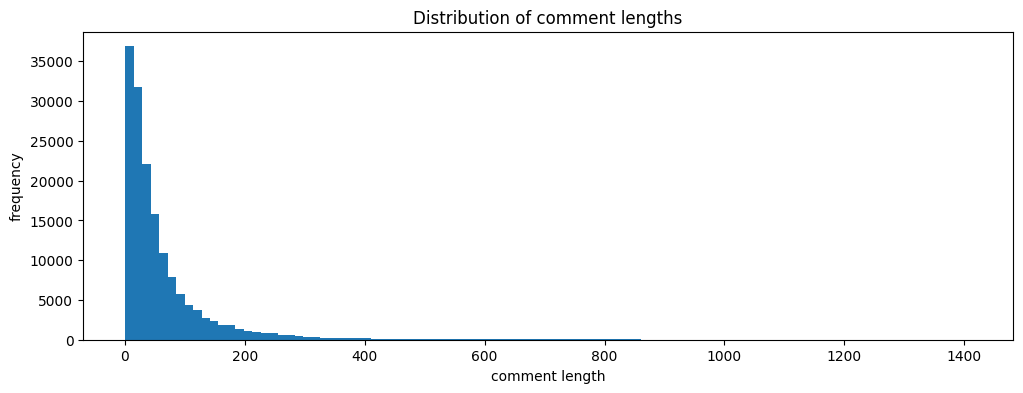

95% of the comments have less than 230 words.


In [12]:
plt.figure(figsize=(12,4))
# Distribution of comment lengths
plt.hist(df["comment_length"],bins=100)
plt.title("Distribution of comment lengths")
plt.xlabel('comment length')
plt.ylabel('frequency')
plt.show()

p_95 = int(np.percentile(df["comment_length"].values,95)) # the 95th percentile 
print(f"95% of the comments have less than {p_95} words.")

95% of the comments for label 'toxic' have less than 171 words.
95% of the comments for label 'severe_toxic' have less than 473 words.
95% of the comments for label 'obscene' have less than 162 words.
95% of the comments for label 'threat' have less than 143 words.
95% of the comments for label 'insult' have less than 151 words.
95% of the comments for label 'identity_hate' have less than 178 words.


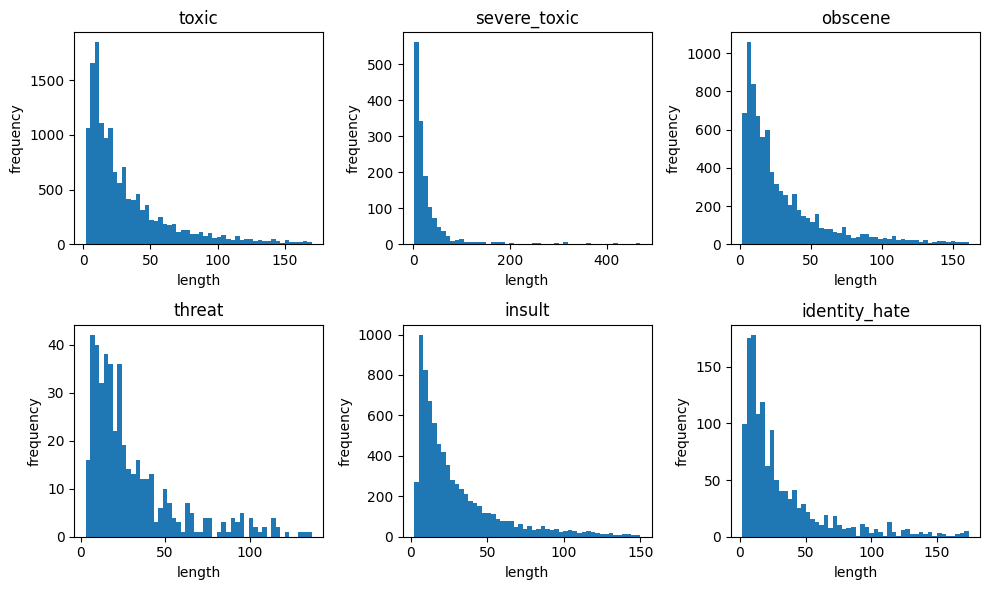

In [13]:
# Distribution of comment lengths per Label
plt.figure(figsize=(10,6))
for i in range(6):
    comments_i = df.loc[df[labels[i]] == 1, :]['comment_length']
    p_95 = int(np.percentile(comments_i,95)) # the 95th percentile
    comments_i = comments_i[comments_i<p_95]
    print(f"95% of the comments for label '{labels[i]}' have less than {p_95} words.")   
    
    # add subplot
    plt.subplot(2,3,i+1)
    plt.hist(comments_i, bins=50)
    plt.xlabel('length')
    plt.ylabel('frequency')
    plt.title(f'{labels[i]}')
plt.tight_layout()
plt.show() 

- We can see that the distribution of the comment lengths for the labels are very similar. 
- 95% of the comments have less than 180 words for all labels except for 'sever_toxic' (473 words).

### Word cloud: The most common words

In [14]:
all_comments =  pd.Series(df["comment_text"]).str.cat(sep=' ')

Text(0.5, 1.0, 'Most common words\n')

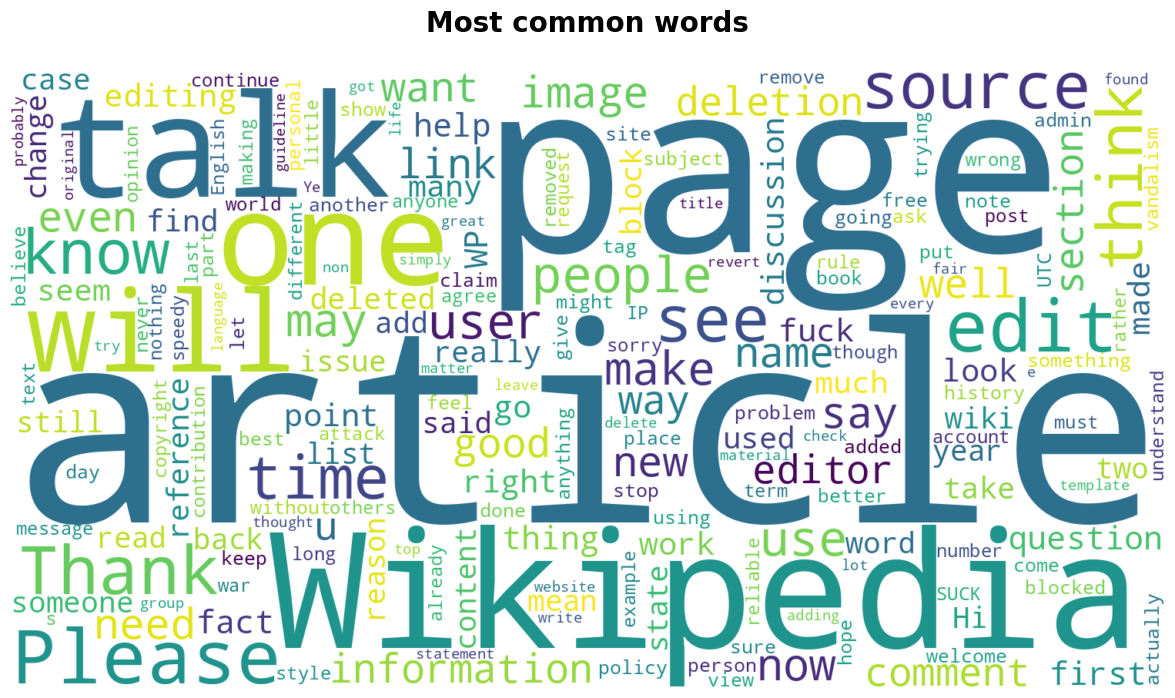

In [15]:
wordcloud = WordCloud(background_color='White', max_words=200, width=1500,height=800,max_font_size=500,collocations=False)
# Generate the word cloud
wordcloud.generate(all_comments)

# display the wordcloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Most common words\n",size = 20, weight = 'bold')

### Word cloud: The most common toxic words

In [16]:
toxic_comments = df[df[labels].sum(axis=1)>0]["comment_text"] # at least on label is positive
toxic_text = pd.Series(toxic_comments).str.cat(sep=' ')

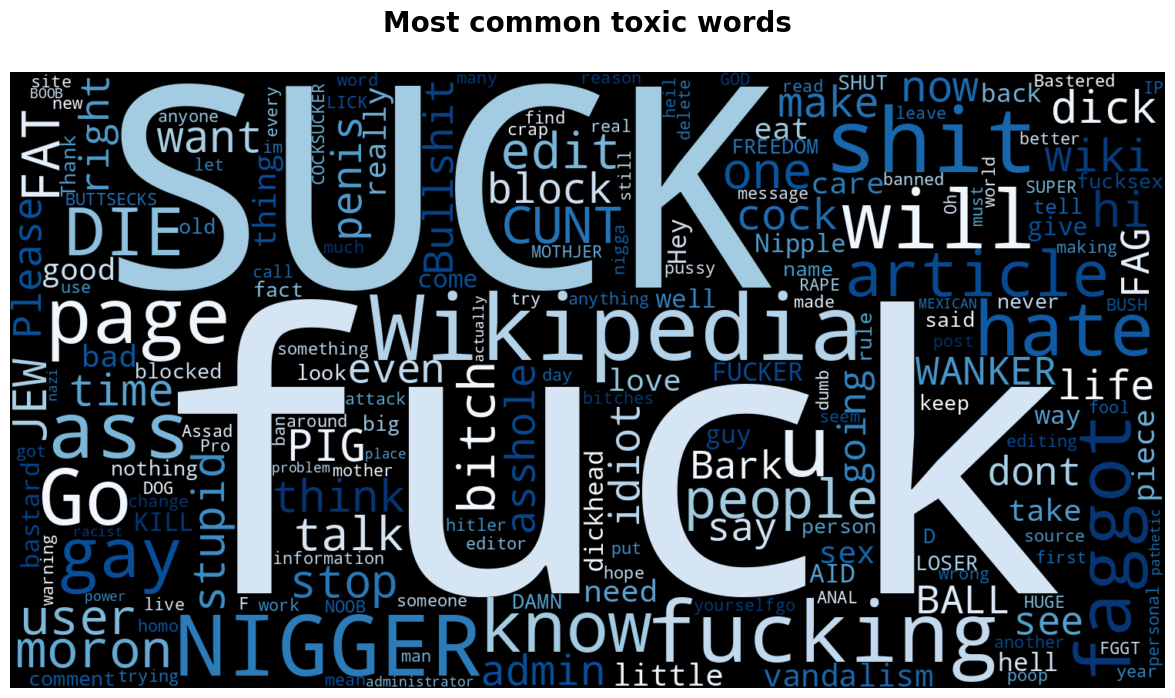

In [17]:
toxic_wordcloud = WordCloud(background_color='black',max_words=200,
                            width=1500,height=800,max_font_size=500,collocations=False)
# Generate the word cloud
toxic_wordcloud.generate(toxic_text)

plt.figure(figsize=(15, 8))
plt.imshow(toxic_wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common toxic words\n",size = 20, weight = 'bold')
plt.show()

#### Top toxic words per label`

In [18]:
toxic_wordclouds = []
for i in range(6):
    toxic_comments_i = df.loc[df[labels[i]] == 1, :]["comment_text"] # at least on label is positive
    toxic_text_i = pd.Series(toxic_comments_i).str.cat(sep=' ')
    
    toxic_wordcloud_i = WordCloud(max_words=200)
    # Generate the word cloud
    toxic_wordcloud_i.generate(toxic_text_i)
    toxic_wordclouds.append(toxic_wordcloud_i.words_)

toxic_wordclouds_df = pd.DataFrame(toxic_wordclouds).T.round(2).fillna(0)
toxic_wordclouds_df.columns = labels

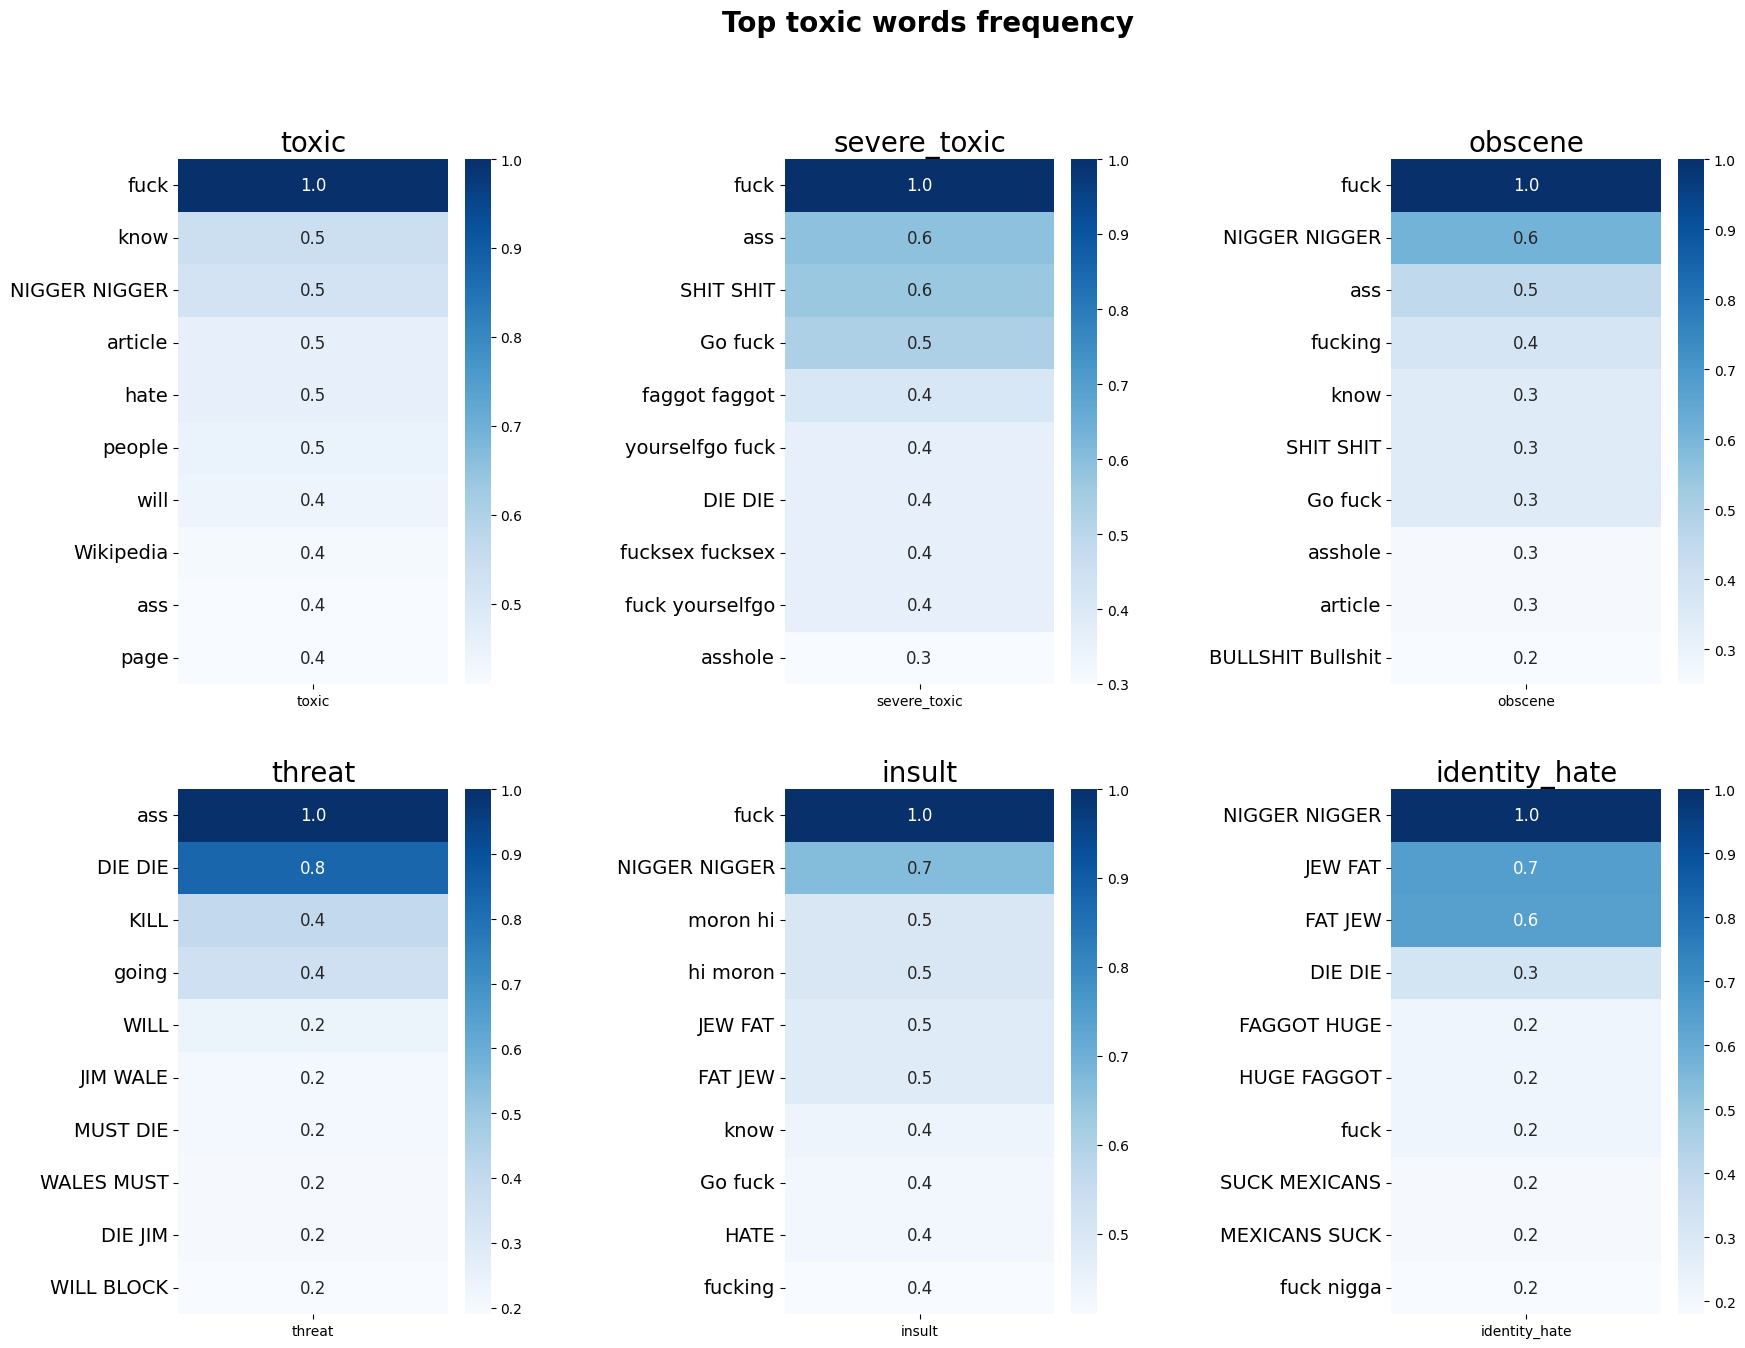

In [19]:
plt.figure(figsize=(20,15))
plt.suptitle('Top toxic words frequency', fontsize=20, weight = 'bold')

for i in range(6):
    top_words_i = pd.DataFrame(toxic_wordclouds_df[labels[i]].sort_values(ascending=False)[:10])
    plt.subplot(2,3,i+1)
    sns.heatmap(top_words_i, fmt='.01f', annot=True,cmap="Blues",annot_kws={"size": 12})
    plt.title(labels[i], fontsize=20)
    plt.yticks(size=14)
plt.subplots_adjust(wspace=0.8)
plt.show()


There is a significant difference in the top 10 toxic words between the different labels, as shown in the graph above.

## Evaluation metric and handling unbalanced dataset

**To deal with class inmbalance, we will:**
1. Use stratified data split instead of the traditional train_test_split..
2. Build a custom binary cross-entropy loss function with class weights.
3. Text Data augmentation to increase the number of minority labels (namely 'threat' and 'identity_hate'). We translate the given comment into French, German and Spanish and then back into English (back-translation).
4. Use the the **F1-score** and **AUC** as evaluation metrics instead of the accuracy.

# Data Preprocessing

In [20]:


def clean_text(text):
    # 1. find urls and replace them with 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)

    # 2. Convert to lowercase
    text = text.lower().strip() 

    # 3. Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 

    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    clean_tokens = [word for word in text.split() if word not in stop_words]
    
    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    # 6.1 Reduce words to their root form
    lemmed = [lemmatizer.lemmatize(w) for w in clean_tokens]
    # 6.2 Lemmatize verbs by specifying pos
    clean_tokens = [WordNetLemmatizer().lemmatize(w, pos='v') for w in lemmed]

    cleaned_text = ' '.join(clean_tokens)
    
    return cleaned_text

In [21]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [22]:
start = time.time()
df["clean_comment"] = df["comment_text"].apply(clean_text)
end = time.time()
print(f"Execution time: {int((end-start)/60)} minutes and {int((end-start)%60)} seconds")
df.head()

Execution time: 1 minutes and 42 seconds


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length,clean_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,43,explanation edit make username hardcore metall...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,17,aww match background colour seemingly stick th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,hey man really try edit war guy constantly rem...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,113,make real suggestion improvement wonder sectio...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,sir hero chance remember page


## Iterative_train_test_split
To deal with data imbalances, we will use the [iterative stratification for multi-label data](http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html) instead of the traditional train_test_split.

In [23]:
# !pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

# Split into X and y
X = df[['clean_comment','comment_text']].to_numpy()
# X = df[['clean_comment']].to_numpy()
y = df[labels].to_numpy()

X_train, y_train, X_test, y_test = iterative_train_test_split(X.reshape((len(df), -1)), y, test_size = 0.3)

In [24]:
print(f"X shape:",X.shape)
print(f"X_train shape:",X_train.shape)
print(f"X_test shape:",X_test.shape)
print(f"y_train shape:",y_train.shape)
print(f"y_test shape:",y_test.shape)

X shape: (159571, 2)
X_train shape: (111699, 2)
X_test shape: (47872, 2)
y_train shape: (111699, 6)
y_test shape: (47872, 6)


## Calculate class weights
We will use these weights to construct our own binary cross-entropy loss function.

In [25]:
class_0_weights = []
class_1_weights = []

for c in labels:
    class_0_weights.append(df.shape[0]/(2*np.count_nonzero(df[c]==0)))
    class_1_weights.append(df.shape[0]/(2*np.count_nonzero(df[c]==1)))    
weights = np.array([class_0_weights,class_1_weights]).T
print(weights)

[[  0.55300221   5.21678436]
 [  0.50504824  50.02225705]
 [  0.52795424   9.44318854]
 [  0.50150227 166.91527197]
 [  0.52596345  10.12891964]
 [  0.50444154  56.78683274]]


In [26]:
# X_train initially contains clean_messages and initial messagaes --> keep only the former 
if X_train.ndim>1:
    X_train = X_train[:,0]
    X_test = X_test[:,0]

# TextVectorization and Embedding

Now, let's turn text into numbers.

### TextVectorization
We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Sequence tokens length: 119


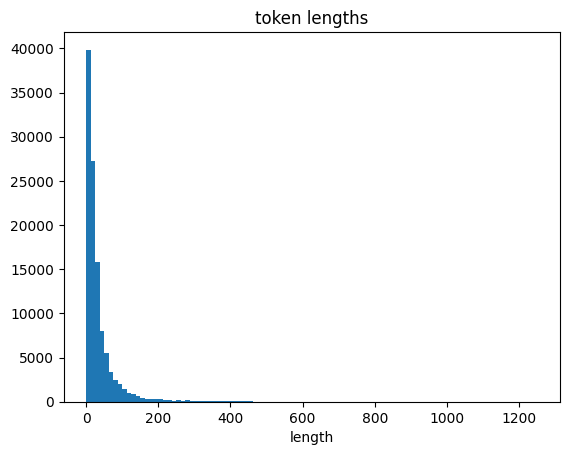

In [27]:
def get_sequence_len(X_train_array):
    clean_Tokens_length = [len(str(sentence).split()) for sentence in X_train_array]
    
    clean_tokens_length_df = pd.DataFrame(clean_Tokens_length, columns=['len'])
    seq_length = int(np.percentile(clean_Tokens_length, 95))
    print(f"Sequence tokens length:", seq_length)
    return seq_length, clean_tokens_length_df

output_sequence_length, seq_len_df = get_sequence_len(X_train)
plt.hist(seq_len_df, bins=100)
plt.xlabel('length')
plt.title('token lengths')
plt.show()

In [28]:
def get_all_tokens(X_train):
    list_tokens = [token for sentence in X_train for token in str(sentence).split()]
    return set(list_tokens)

def get_max_tokens(X_train):
    max_tokens = len(get_all_tokens(X_train))
    print(f"MAX_tokens:", max_tokens)
    return max_tokens

In [29]:
def get_vocab(X_train):
    all_tokens = get_all_tokens(X_train)
    vocab = {word: idx + 1 for idx, word in enumerate(all_tokens)}  # +1 to reserve index 0 for padding
    return vocab

In [30]:
vocab = get_vocab(X_train)

In [31]:
np.save('vocabulary.npy', vocab)

In [32]:
len(vocab)

124329

In [33]:
def vectorize_sentence(sentence, vocab):
    vector = [vocab.get(token, 0) for token in str(sentence).split()]  # Replace unseen words with 0
    diff = output_sequence_length - len(vector) # for padding 
    if diff < 0:
        vector = vector[:output_sequence_length]
    else:
        vector = vector + [0]*diff
    return vector

In [34]:
def vectorizer(texts, vocab):
    return [vectorize_sentence(text, vocab) for text in texts]

In [35]:
vectorized_sentences = vectorizer(X_train, vocab)

## Embedding
We will create a trainable embedding layer using PyTorch's Embedding class

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

In [36]:
class EmbeddingLayer(nn.Module):
    def __init__(self, max_tokens, embedding_dim):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=max_tokens + 1,  # +1 to include padding index
                                      embedding_dim=embedding_dim,
                                      padding_idx=0)  # Zero index for padding
    
    def forward(self, x):
        return self.embedding(x)

In [37]:
tokens_Embedding = EmbeddingLayer(max_tokens=get_max_tokens(X_train), embedding_dim=128)

MAX_tokens: 124329


In [38]:
# Show an embedding example
import random
# Get a random comment from training set
random_comment = random.choice(X_train)
print(f"Original text:\n{random_comment}\n\nEmbedded version:")

# Embed the random sentence 
sample_embed = tokens_Embedding(torch.tensor(vectorize_sentence(random_comment, vocab)))
print(len(sample_embed))
sample_embed

Original text:
listen sj go let show wrong first offer email address could email second wrong attack feed incompetence site justifiable guy see vandal desire bring back civilize behavior 4 chan people u much education ever smarter ever connection unwilling let dang well please also tone hear satire believe hate mail talk page downfall site tool want irc want even computer operate system warn warn issue vandal seek happy user complain warn even issue demonstrate completely incompetent could maybe start work towards address topic

Embedded version:
119


tensor([[ 3.9421e-02,  1.6253e-01,  9.6378e-01,  ...,  4.8911e-01,
          3.9778e-01, -1.3792e+00],
        [-5.7673e-01, -9.6709e-04,  3.8289e-01,  ...,  5.5136e-01,
         -5.8250e-01, -2.2219e-01],
        [-1.8917e+00,  7.8046e-01, -1.0539e+00,  ...,  2.9281e-01,
         -2.1186e-01, -3.9769e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], grad_fn=<EmbeddingBackward0>)

# Custom Dataset

In [39]:
class ToxicCommentDataset(Dataset):
    def __init__(self, texts, targets, vectorizer, vocab):
        self.texts = texts
        self.targets = targets
        self.vectorizer = vectorizer
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
#         print('index', index)
        text = self.texts[index]
#         print('text', text)
        target = self.targets[index]
#         print('target', target)
        vectorized_text = self.vectorizer(text, vocab)
#         print('vec', vectorized_text)
        ret = {
          'input_ids': torch.tensor(vectorized_text, dtype=torch.long),
          'targets': torch.tensor(target, dtype=torch.float)
        }
#         print('ret', ret)
        return ret

In [40]:
# testing the dataset
data = ToxicCommentDataset(X_train, y_train, vectorize_sentence, vocab)

In [41]:
len(data[1]['input_ids'])

119

# Modelling and Evaluation

Model structure:
```
Input (text) -> TextVectorization -> Embedding -> LSTM Layer -> Output (sigmoid)
```

## Build a custom binary cross-entropy loss function with class weights
https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras

In [42]:
def get_weighted_loss(weights):
    bce_loss = nn.BCELoss(reduction='none')
    def weighted_loss(y_true, y_pred):
        loss = bce_loss(y_pred, y_true)
        w_loss = (weights[:,0]**(1-y_true))*(weights[:,1]**y_true)*loss
        return w_loss.mean() 
    return weighted_loss

In [43]:
loss_functions = [nn.BCELoss(), get_weighted_loss(weights)]

# Model: LSTM

In [44]:
class LSTMToxicClassifier(nn.Module):
    def __init__(self, MAX_tokens, name='LSTM_toxic_classifier'):
        super(LSTMToxicClassifier, self).__init__()
        self.name = name
        self.embedding = nn.Embedding(num_embeddings = MAX_tokens+1, embedding_dim = 128, padding_idx=0)
        self.lstm = nn.LSTM(input_size=128, hidden_size=32, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features= 64, out_features=16)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=16, out_features=6)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_tensors):
        embeddings = self.embedding(input_tensors)
        lstm_out, _ = self.lstm(embeddings)
        lstm_out = self.dropout1(lstm_out)
        last_element = lstm_out[:,-1,:]
        fc_out = self.fc1(last_element)
        fc_out = self.relu(fc_out)
        out = self.dropout2(fc_out)
        out = self.fc2(out)
        prob = self.sigmoid(out)
        return prob

## Create functions to train and evaluate our models

In [45]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.early_stop = False
        self.counter = 0
        
    def __call__(self, val_loss, model, checkpoint_filepath):
        if val_loss < self.best_loss:
            self.save_checkpoint(val_loss, model, checkpoint_filepath)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
    def save_checkpoint(self, val_loss, model, checkpoint_filepath):
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), checkpoint_filepath)
        self.best_loss = val_loss

In [46]:
def train_model(model,weights, train_loader, test_loader, epochs, device):
    checkpoint_filepath = os.path.join("/kaggle/working/model_ckpt/", "model_weights.pth")
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters())
#     weights_tensor = torch.tensor(weights).to(device)
#     criterion = get_weighted_loss(weights_tensor)  # or another appropriate loss function
    criterion = nn.BCELoss()  # or another appropriate loss function

    # Initialize early stopping and learning rate scheduler
    early_stopping = EarlyStopping(patience=4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.2, min_lr=1e-7)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_auc': [], 'val_auc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        # Training loop
        for batch in tqdm.tqdm(train_loader):
            inputs, targets = batch['input_ids'].to(device), batch['targets'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(targets.cpu().numpy())
            all_preds.extend((outputs.cpu().detach().numpy()>0.5).astype(int))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['train_auc'].append(epoch_auc)
        print(f"epoch {epoch+1}: train loss: {epoch_loss}, train accuracy: {epoch_acc}, train auc: {epoch_auc}")
        

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in tqdm.tqdm(test_loader):
                inputs, targets = batch['input_ids'].to(device), batch['targets'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_labels.extend(targets.cpu().numpy())
                val_preds.extend((outputs.cpu().detach().numpy() > 0.5).astype(int))

        epoch_val_loss = val_loss / len(test_loader.dataset)
        epoch_val_acc = accuracy_score(val_labels, val_preds)
        epoch_val_auc = roc_auc_score(val_labels, val_preds, multi_class='ovr')

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)
        print(f"epoch {epoch+1}: val loss: {epoch_val_loss}, val accuracy: {epoch_val_acc}, val auc: {epoch_val_auc}")
        
        scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss
        early_stopping(epoch_val_loss, model, checkpoint_filepath)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return history

In [47]:
def make_predictions_batch(model, test_dataset):
    model.eval()
    val_preds = []

    with torch.no_grad():
        for batch in tqdm.tqdm(test_loader):
            inputs, targets = batch['input_ids'].to(device), batch['targets'].to(device)
            outputs = model(inputs)
            val_preds.extend(outputs.cpu().detach().numpy())
    
    return np.array(val_preds)

In [48]:
def plot_metrics(history,model_name,list_metrics=['loss','auc']):
    """Plot list of metrics"""
    for metric in list_metrics:
        train_metric = history[f"train_{metric}"]
        val_metric = history[f"val_{metric}"]
        epochs = [i for i in range(len(train_metric))]
        
        plt.figure(figsize=(7, 5))
        plt.plot(epochs, train_metric, label=f"training_{metric}")
        plt.plot(epochs, val_metric, label=f"val_{metric}")
        plt.title(f"{str.upper(metric)} - {model_name}")
        plt.xlabel('Epochs')
        plt.legend()

In [49]:
def evaluate_model(probs,preds,y_true,labels,label_inedx,plot_ROC_AUC=False):
    """
    - Print AUC, accuracy, precision, recall, and f1_score on the test set
    - Plot ROC AUC
    
    Parameters
    ----------- 
        probs: an array of predicted probabilities 
        preds: an array of predictions
        y_true: true y values 
        labels (list): model's labels (toxic, severe_toxic, obscene, threat, insult, identity_hate)
        label_inedx (int): label index, in range(0,6)
        plot_ROC_AUC (boolean): plot ROC AUC or not, default=False
    """
    
    y_probs = probs[:, label_inedx]
    y_pred = preds[:, label_inedx]
    y_true = y_true[:,label_inedx]
    
    print(f"\n{labels[label_inedx]}:")
    print("#"*50)
    
    fpr, tpr, threshold = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')       
       
    # Get accuracy over the test set
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Get precision, recall, and F-measure
    precision,recall,f1_score,_, = precision_recall_fscore_support(y_true, y_pred,average="weighted")    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1_score: {f1_score:.4f}')    
    
    # Plot ROC AUC
    if plot_ROC_AUC:
        plt.figure()
        plt.title(f"Receiver Operating Characteristic - {labels[label_inedx]}")
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [50]:
def get_metrics_per_class(y_test, y_pred,probs,model_name,labels):
    """
    Build a dataframe showing the main classification metrics 
        per label (toxic, severe_toxic...) and class (0, 1 and weigted avg).
    Metrics: Accuracy, ROC, f1_score,precision 
    
    Parameters
    ----------- 
        y_test: true y values 
        y_pred: predicted y values
        probs: an array of predicted probabilities
        model_name (str): the model name
        labels (list): model's labels (toxic, severe_toxic, obscene, threat, insult, identity_hate)  
        
    Returns
    ----------- :
        df_metrics_report: A dataframe containing classification metrics 
            per category (toxic, severe_toxic...) and class (0, 1 and weigted avg)
    """
    
    class_list = ["0","1","weighted avg"]
    reports_list = []
    
    for indice,category in enumerate(labels):
        # 1. calssification report        
        report = classification_report(y_test[:,indice], y_pred[:,indice], output_dict=True)
        
        # 2. accuracy
        try:
            accuracy = accuracy_score(y_test[:,indice], y_pred[:,indice])
        except:
            accuracy = np.nan
            
        # 3. roc_auc_score
        try:
            roc = roc_auc_score(y_test[:,indice], probs[:,indice])
        except:
            roc = np.nan
            
        # 4. Build the list of dicts (will be used to create a dataframe)
        for class_name in class_list:
            try:
                report_class = report.get(class_name)
                
                # Accuracy and roc_auc scores are available only for weighted avg
                if class_name == "weighted avg":
                    report_class["accuracy"] = accuracy
                    report_class["ROC"] = roc
                else:
                    report_class["accuracy"] = np.nan
                    report_class["ROC"] = np.nan
                
                report_class["category"] = category 
                report_class['class'] = class_name 
                report_class['model_name'] = model_name                
                reports_list.append(report_class)
            except:
                pass
        
    # 5. create the dataframe:
    df_metrics_report  = pd.DataFrame(reports_list)   
    # save metrics
    df_metrics_report.to_csv("/kaggle/working/stats/metrics_"+model_name+".csv",index=False)
    
    return df_metrics_report      

In [51]:
def train_evaluate_model(model,weights,train_dataset,test_dataset,y_test,labels,epochs=3,list_metrics=['loss','auc'], device='cpu'):
    # 1. Train the model
    history = train_model(model,weights,train_dataset,test_dataset,epochs,device)
    history_df = pd.DataFrame(history)
    history_df['model_name'] = model.name
    try:
        history_df.to_csv("/kaggle/working/stats/history_"+model.name+".csv",index=False)
    except:
        print("can not save file!")    
    
    # 2. Plot loss curves
    plot_metrics(history,model.name,list_metrics)
    
    # 3. Evaluate the model    
    ###################################
    probs = make_predictions_batch(model, test_dataset)
    preds = np.array(probs > 0.5, dtype=int)
    
    # 3.1 create a dataframe using classification report
    cls_report_dict = classification_report(y_test, preds,output_dict=True)
    cls_report_df = pd.DataFrame(cls_report_dict).T
    cls_report_df["model_name"] = model.name

    # 3.2 Print classification report and average roc_auc_score    
    cls_report = classification_report(y_test, preds)
    print(cls_report)  

    # 3.3 Print average roc_auc_score
    roc = roc_auc_score(y_test, probs,average='weighted')
    print(f"Average roc_auc_score: {roc:.4f}")
    
    # 3.4 Print/plot metrics per category
    # for i in range(len(labels)):
    #     evaluate_model(probs,preds,y_test,labels,i,plot_ROC_AUC=False)

    # 4. Get metrics per class
    ###################################
    df_metrics = get_metrics_per_class(y_test,preds,probs,model.name,labels)
    df_metrics.to_csv("/kaggle/working/stats/metrics_"+model.name+".csv",index=False)    
    
    return probs,preds,df_metrics,roc,cls_report_df

In [52]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Extract lists of inputs and targets from the batch of dictionaries
    inputs = [item['input_ids'] for item in batch]
    targets = [item['targets'] for item in batch]
    
    # Pad input sequences to the same length
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    
    # Stack targets (assuming targets do not need padding)
    targets_stacked = torch.stack(targets)
    
    return {'input_ids': inputs_padded, 'targets': targets_stacked}

In [53]:
np.random.seed(41)
torch.manual_seed(41)
max_tokens = get_max_tokens(X_train)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMToxicClassifier(max_tokens).to(device)  # Replace `YourModel` with your model class
train_dataset = ToxicCommentDataset(X_train, y_train, vectorize_sentence, vocab)
test_dataset = ToxicCommentDataset(X_test, y_test, vectorize_sentence, vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

MAX_tokens: 124329


100%|██████████| 3491/3491 [00:30<00:00, 112.83it/s]


epoch 1: train loss: 0.15296069393351747, train accuracy: 0.8893723309966964, train auc: 0.5002539553224056


100%|██████████| 1496/1496 [00:04<00:00, 331.99it/s]


epoch 1: val loss: 0.13935980394253517, val accuracy: 0.8984375, val auc: 0.5009377077257212
Validation loss decreased (inf --> 0.139360). Saving model ...


100%|██████████| 3491/3491 [00:30<00:00, 115.85it/s]


epoch 2: train loss: 0.14024910145823588, train accuracy: 0.8972864573541393, train auc: 0.5038283378732865


100%|██████████| 1496/1496 [00:04<00:00, 343.12it/s]


epoch 2: val loss: 0.12313715462264092, val accuracy: 0.8984375, val auc: 0.5031135498906059
Validation loss decreased (0.139360 --> 0.123137). Saving model ...


100%|██████████| 3491/3491 [00:30<00:00, 115.38it/s]


epoch 3: train loss: 0.12264287965368285, train accuracy: 0.8986114468347971, train auc: 0.5053616365463535


100%|██████████| 1496/1496 [00:04<00:00, 336.94it/s]


epoch 3: val loss: 0.12063725502479243, val accuracy: 0.8986463903743316, val auc: 0.5048076336877824
Validation loss decreased (0.123137 --> 0.120637). Saving model ...


100%|██████████| 3491/3491 [00:29<00:00, 116.50it/s]


epoch 4: train loss: 0.12100337692907988, train accuracy: 0.8986920205194316, train auc: 0.505854481123733


100%|██████████| 1496/1496 [00:04<00:00, 343.62it/s]


epoch 4: val loss: 0.11969131021635895, val accuracy: 0.8985210561497327, val auc: 0.5037131018400228
Validation loss decreased (0.120637 --> 0.119691). Saving model ...


100%|██████████| 3491/3491 [00:29<00:00, 117.03it/s]


epoch 5: train loss: 0.11919254461492004, train accuracy: 0.8989068836784573, train auc: 0.5063047998482803


100%|██████████| 1496/1496 [00:04<00:00, 342.49it/s]


epoch 5: val loss: 0.11919938604207958, val accuracy: 0.8985837232620321, val auc: 0.5037736214723717
Validation loss decreased (0.119691 --> 0.119199). Saving model ...


100%|██████████| 3491/3491 [00:31<00:00, 109.82it/s]


epoch 6: train loss: 0.11749697604887302, train accuracy: 0.8987188784143099, train auc: 0.5067169993404764


100%|██████████| 1496/1496 [00:04<00:00, 310.71it/s]


epoch 6: val loss: 0.11766049876575045, val accuracy: 0.8986881684491979, val auc: 0.5047373093034926
Validation loss decreased (0.119199 --> 0.117660). Saving model ...


100%|██████████| 3491/3491 [00:31<00:00, 109.12it/s]


epoch 7: train loss: 0.11613499131988686, train accuracy: 0.8990680310477265, train auc: 0.5071839271630779


100%|██████████| 1496/1496 [00:04<00:00, 316.79it/s]


epoch 7: val loss: 0.11903320127266415, val accuracy: 0.8986672794117647, val auc: 0.5050048939734559


100%|██████████| 3491/3491 [00:32<00:00, 108.96it/s]


epoch 9: train loss: 0.11166820260012873, train accuracy: 0.8957555573460819, train auc: 0.5113288067470497


100%|██████████| 1496/1496 [00:04<00:00, 320.07it/s]


epoch 9: val loss: 0.1063563906641199, val accuracy: 0.8981868315508021, val auc: 0.5051923425185921
Validation loss decreased (0.117660 --> 0.106356). Saving model ...


100%|██████████| 3491/3491 [00:32<00:00, 108.36it/s]


epoch 10: train loss: 0.0996215844684788, train accuracy: 0.8981369573586155, train auc: 0.5091554849540203


100%|██████████| 1496/1496 [00:04<00:00, 322.49it/s]


epoch 10: val loss: 0.09751072896826256, val accuracy: 0.898019719251337, val auc: 0.5058919185979228
Validation loss decreased (0.106356 --> 0.097511). Saving model ...


100%|██████████| 3491/3491 [00:32<00:00, 108.73it/s]


epoch 11: train loss: 0.09006148162318374, train accuracy: 0.8878593362518913, train auc: 0.5205838536395456


100%|██████████| 1496/1496 [00:04<00:00, 310.75it/s]


epoch 11: val loss: 0.09349580252833196, val accuracy: 0.8976019385026738, val auc: 0.5058696773116046
Validation loss decreased (0.097511 --> 0.093496). Saving model ...


100%|██████████| 3491/3491 [00:32<00:00, 108.44it/s]


epoch 12: train loss: 0.0800872149762714, train accuracy: 0.8799452098944485, train auc: 0.5374450768253517


100%|██████████| 1496/1496 [00:04<00:00, 312.91it/s]


epoch 12: val loss: 0.08245423560307479, val accuracy: 0.8665608288770054, val auc: 0.5656875581990147
Validation loss decreased (0.093496 --> 0.082454). Saving model ...


100%|██████████| 3491/3491 [00:32<00:00, 108.81it/s]


epoch 13: train loss: 0.07180492613326486, train accuracy: 0.876919220404838, train auc: 0.570842526902997


100%|██████████| 1496/1496 [00:04<00:00, 311.76it/s]


epoch 13: val loss: 0.07276114067592285, val accuracy: 0.9073362299465241, val auc: 0.6181614086834986
Validation loss decreased (0.082454 --> 0.072761). Saving model ...


100%|██████████| 3491/3491 [00:32<00:00, 108.41it/s]


epoch 14: train loss: 0.05544969819791371, train accuracy: 0.9110018890052731, train auc: 0.6444315927083059


100%|██████████| 1496/1496 [00:04<00:00, 318.79it/s]


epoch 14: val loss: 0.06074355456577788, val accuracy: 0.9141460561497327, val auc: 0.6590633076998831
Validation loss decreased (0.072761 --> 0.060744). Saving model ...


100%|██████████| 3491/3491 [00:32<00:00, 108.30it/s]


epoch 15: train loss: 0.046778232615336125, train accuracy: 0.9163107995595305, train auc: 0.6718840258365028


100%|██████████| 1496/1496 [00:04<00:00, 315.10it/s]


epoch 15: val loss: 0.06341485580987427, val accuracy: 0.9109082553475936, val auc: 0.6678583135709526


100%|██████████| 3491/3491 [00:32<00:00, 108.17it/s]


epoch 16: train loss: 0.04222987520258526, train accuracy: 0.9212436995854931, train auc: 0.6873898303555984


100%|██████████| 1496/1496 [00:04<00:00, 312.22it/s]


epoch 16: val loss: 0.06376390841363959, val accuracy: 0.9098429144385026, val auc: 0.6742689411809577


100%|██████████| 3491/3491 [00:32<00:00, 108.25it/s]


epoch 17: train loss: 0.039812843263555886, train accuracy: 0.9238310101254263, train auc: 0.6929689369551927


100%|██████████| 1496/1496 [00:04<00:00, 318.93it/s]


epoch 17: val loss: 0.0659548672641099, val accuracy: 0.9042028743315508, val auc: 0.6764075821747819


100%|██████████| 3491/3491 [00:32<00:00, 108.04it/s]


epoch 18: train loss: 0.03629344929464452, train accuracy: 0.9308588259518885, train auc: 0.7012225431415543


100%|██████████| 1496/1496 [00:04<00:00, 312.93it/s]


epoch 18: val loss: 0.06866386927201205, val accuracy: 0.9092789104278075, val auc: 0.6713457864683187
Early stopping triggered


100%|██████████| 1496/1496 [00:04<00:00, 344.85it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/pyth

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      4588
           1       0.86      0.01      0.02       478
           2       0.82      0.73      0.77      2535
           3       0.00      0.00      0.00       143
           4       0.72      0.62      0.66      2363
           5       0.00      0.00      0.00       426

   micro avg       0.77      0.64      0.70     10533
   macro avg       0.53      0.35      0.37     10533
weighted avg       0.73      0.64      0.66     10533
 samples avg       0.07      0.06      0.06     10533

Average roc_auc_score: 0.9632


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

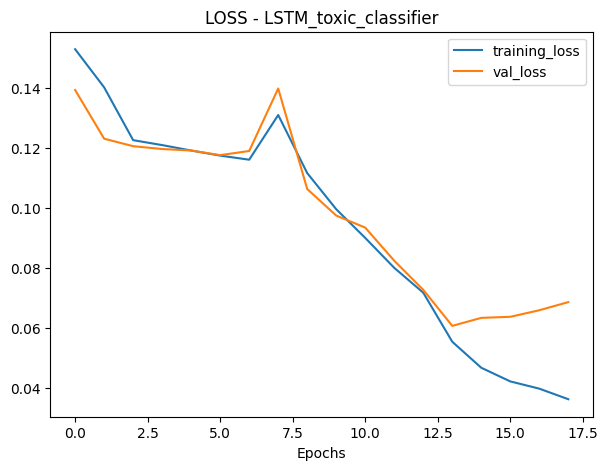

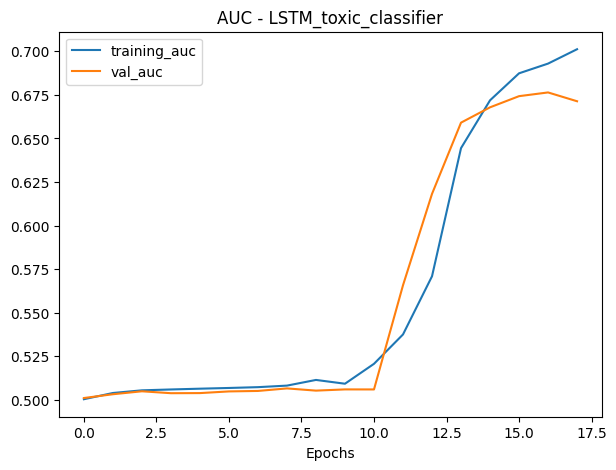

In [54]:
probs,preds,df_metrics,roc,cls_report_df = train_evaluate_model(model, weights, train_loader, test_loader, y_test, labels, epochs=20, device=device)

# Save ROCs to csv file
roc_model = pd.DataFrame([{model.name:roc}],index=["ROC"]).T.reset_index()
roc_model.to_csv("/kaggle/working/stats/roc_lastm_tanh.csv",index=False)

# Predictions

In [78]:
def predict(text,model, vectorizer, vocab, labels, device):
    input_vector = vectorizer(text,vocab)
    model.eval()
    tensor_input = torch.tensor(input_vector).unsqueeze(0)
    with torch.no_grad():
        output = model(tensor_input.to(device))
        output = output.cpu().numpy()
#         print(output)
    return {key:output[0][i] for i,key in enumerate(labels)} 

In [77]:
predict('thank you for your help. actually i was really facing this issue but know i am fines. thanks fellas.', model, vectorize_sentence, vocab, labels, device)

torch.Size([1, 119])
[[2.2641019e-04 2.5257636e-09 1.0874041e-06 1.0668423e-05 2.6016039e-06
  8.8928937e-07]]


{'toxic': 0.0002264102,
 'severe_toxic': 2.5257636e-09,
 'obscene': 1.0874041e-06,
 'threat': 1.0668423e-05,
 'insult': 2.601604e-06,
 'identity_hate': 8.8928937e-07}

In [1]:
test_sentences = ["I really appreciate your hard work on this project.",
                  "Thank you for the constructive feedback.",
                  "I hope you have a great day!",
                  "Let's work together to find a solution.",
                  "Your idea is interesting and worth exploring",
                  "You're not really making much sense here.",
                  "That's not the smartest approach, is it?",
                  "I don't think you understand the topic well.",
                  "Your comment is kind of annoying.",
                  "Can you please stop spamming the chat?",
                  "Your work is just pathetic.",
                  "Why do you always mess things up?",
                  "This is the dumbest idea I've ever heard.",
                  "You're so clueless.",
                  "Nobody cares about your opinion.",
                  "You're a complete idiot.",
                  "Get lost, nobody wants you here.",
                  "You're the worst, just shut up.",
                  "I can't stand your stupidity.",
                  "You're a total failure in life.",
                  "shut the fuck up",
                  "you are misogynist",
                  "hello there"
                 ]

for text in test_sentences:
    print(text)
    prediction = predict(text, model, vectorize_sentence, vocab, labels, device)
    print(prediction)
    print('-----------------------------------------------------')

I really appreciate your hard work on this project.
{'toxic': 0.00026034276, 'severe_toxic': 3.0970393e-09, 'obscene': 1.2954673e-06, 'threat': 1.19369015e-05, 'insult': 3.093277e-06, 'identity_hate': 1.0455749e-06}
-----------------------------------------------------
Thank you for the constructive feedback.
{'toxic': 0.014700042, 'severe_toxic': 1.1502397e-06, 'obscene': 0.00020679223, 'threat': 0.00031697133, 'insult': 0.00046949557, 'identity_hate': 0.000116740084}
-----------------------------------------------------
I hope you have a great day!
{'toxic': 0.00033467653, 'severe_toxic': 4.4718407e-09, 'obscene': 1.7755935e-06, 'threat': 1.4614567e-05, 'insult': 4.2242355e-06, 'identity_hate': 1.3993734e-06}
-----------------------------------------------------
Let's work together to find a solution.
{'toxic': 0.0002942182, 'severe_toxic': 3.7034693e-09, 'obscene': 1.5103715e-06, 'threat': 1.3172768e-05, 'insult': 3.6000567e-06, 'identity_hate': 1.2049879e-06}
----------------------

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [55]:
# !cd /kaggle/working

In [56]:
# !ls

In [57]:
# !ls

In [58]:
# !ls

In [59]:
# !pwd